# julia言語でポアソン混合モデルを実装する(n番煎じ) 

~~ネットに頼ればJulia完全理解者がより速いコードを教えてくれるらしいので，~~Juliaでポアソン混合モデルを実装してみました。

須山さんの「ベイズ推論による機械学習」の第4章です。

変分推論の勉強中だったのでGibbs SamplingではなくVariational Bayesです。というか個人的にDeterministicな方法が好きなので，変分推論です。

一部だけ須山さんの[サポートページ](https://github.com/sammy-suyama/BayesBook/blob/master/src/PoissonMixtureModel.jl)のコードを参考にしています。

ポアソン混合モデルの活用については詳しくないのですが，非負離散量の分布なので，たとえばテスト得点で群分けするのに使えたりするんじゃないでしょうか。

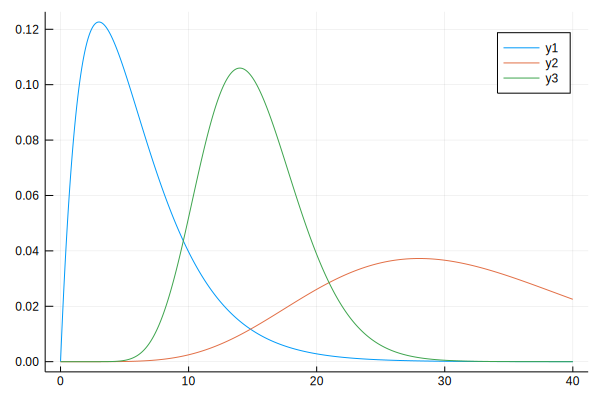

In [2]:
using Distributions, StatsBase, StatsFuns, Plots, Random, SpecialFunctions

N = 10000 # sample n
Sn =  rand(Categorical([0.3, 0.3, 0.4 ]), N)# latent cluster

Khyper = [2 3; 8 4; 15 1]
plot([0:0.01:40;], pdf.(Gamma(Khyper[1,1], Khyper[1,2]), [0:0.01:40;]))
plot!([0:0.01:40;], pdf.(Gamma(Khyper[2,1], Khyper[2,2]), [0:0.01:40;]))
plot!([0:0.01:40;], pdf.(Gamma(Khyper[3,1], Khyper[3,2]), [0:0.01:40;]))

In [3]:
Random.seed!(204)
λ = [rand(Gamma(Khyper[i,1], Khyper[i,2])) for i in 1:3 ]
X = [ rand(Poisson(λ[Sn[i]]), 1)[1] for i in 1:length(Sn)]
X'

1×10000 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 2  37  5  37  1  15  16  29  3  16  …  16  13  22  8  3  16  1  38  4  37

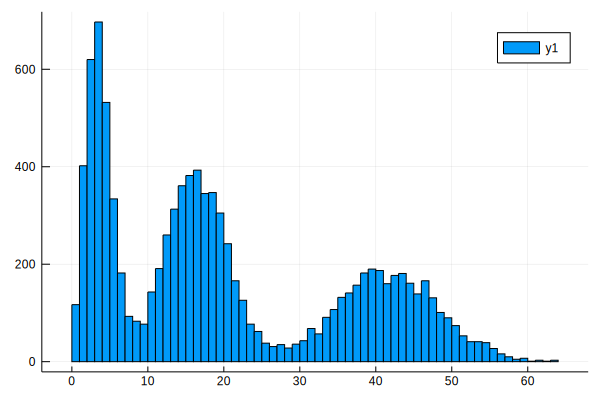

In [4]:
plot(fit(Histogram, X, nbins = 100))

今回はこんな感じのデータを用意します。一次元の非負離散変数を混合ポアソン分布から発生させました。混合比率は`Categorical([0.3, 0.3, 0.4 ])`で指定して，ポアソン分布の超パラは`λ`，その`λ`自体はガンマ分布`Gamma()`から生成しました。

次に変分推論を実行するための関数を書き下します。

In [5]:
struct MixturePoissonVB
    η
    λ
    shape
    scale
    α
end

function vb(X, nK, MAXITER = 10,
            a = sample([1:1:40;], nK), # Gamma hyper param(shape)
            b = sample([1:1:40;], nK), # Gamma hyper param(scale)
            α = sample([1:1:40;], nK)  # Dirichrret hyper param
            )
    N = length(X)
    # initialize distribution (Expectation)
    Sn =  rand(Categorical(ones(nK)/nK), N)# cluster
    S = zeros(Int64, N, nK)
    println("Initialize latent matrix")
    for k in 1:nK
        S[findall(x->x==k, Sn), k] .= 1
    end
    SnX =  S' * X
    sumS = sum(S', dims = 2)
    println("Initialize parameter vectors")
    # empty vectors
    a1 = zeros(nK);b1 = zeros(nK);α1 = zeros(nK)
    lnλ1 = zeros(nK);lnπ1 = zeros(nK);λ1 = zeros(nK)
    η1 = zeros(N, nK)
    for k in 1:nK
        a1[k] = SnX[k] + a[k]
        b1[k] = sumS[k] + b[k]
        α1[k] = sumS[k] + α[k]
        λ1[k] = a1[k] / b1[k]
        lnλ1[k] = digamma(a1[k]) - log(b1[k])
        lnπ1[k] = digamma(α1[k]) - digamma(sum(α1))
    end
    # VB ITERATION
    ITER = 0
    while ITER < (MAXITER + 1)
        print("Itaration", ITER, "... λ is ")
        println(λ1)
        ITER += 1
        # Expectation of Sn
        for i in 1:N
            η1[i,:] = exp.(X[i] * lnλ1 - λ1 + lnπ1)
            η1[i,:] .= η1[i,:] / sum(η1[i,:]) # shoud use logsumexp ?
        end
        # Expectation of λ and π
        ηX =  η1' * X
        sumη = sum(η1', dims = 2) # total probability of each cluster
        for k in 1:nK
            a1[k] = ηX[k] + a[k]
            b1[k] = sumη[k] + b[k]
            α1[k] = sumη[k] + α[k]
            λ1[k] = a1[k] / b1[k]
            lnλ1[k] = digamma(a1[k]) - log(b1[k])
            lnπ1[k] = digamma(α1[k]) - digamma(sum(α1))
        end
    end # of while
    MixturePoissonVB(η1, λ1, a1, b1, α1)
end # of function

vb (generic function with 5 methods)

ちょっとまだ関数が未熟でELBOによる収束判断を実装できていません。推定すべきパラメタは潜在変数`Sn`とポアソン分布，ガンマ分布，ディリクレ分布のパラメタです。

In [18]:
λ # 真値

3-element Array{Float64,1}:
  3.1272608113496094
 41.148909106061154 
 16.084052566969888 

まずは事前分布であるガンマ分布とディリクレ分布の超パラをランダムに設定します。これだけのデータ数があれば，概ね大抵の事前分布であっても，データに見合った推定値が得られるはずです。

In [7]:
@time res1 = vb(X, 3, 100)

Initialize latent matrix
Initialize parameter vectors
Itaration0... λ is [19.4747, 20.128, 20.019]
Itaration1... λ is [16.5266, 24.5148, 22.9295]
Itaration2... λ is [9.06952, 37.9468, 29.3673]
Itaration3... λ is [8.63289, 41.2114, 23.8154]
Itaration4... λ is [7.41936, 41.6757, 20.1111]
Itaration5... λ is [5.69185, 41.4263, 18.1008]
Itaration6... λ is [4.1456, 41.2581, 16.9235]
Itaration7... λ is [3.41642, 41.1582, 16.328]
Itaration8... λ is [3.22317, 41.1039, 16.098]
Itaration9... λ is [3.17612, 41.0804, 16.023]
Itaration10... λ is [3.16385, 41.0717, 16.0007]
Itaration11... λ is [3.16052, 41.0688, 15.9942]
Itaration12... λ is [3.15959, 41.0679, 15.9924]
Itaration13... λ is [3.15934, 41.0677, 15.9918]
Itaration14... λ is [3.15926, 41.0676, 15.9917]
Itaration15... λ is [3.15924, 41.0676, 15.9916]
Itaration16... λ is [3.15924, 41.0676, 15.9916]
Itaration17... λ is [3.15924, 41.0676, 15.9916]
Itaration18... λ is [3.15924, 41.0676, 15.9916]
Itaration19... λ is [3.15924, 41.0676, 15.9916]
It

MixturePoissonVB([0.99991 5.98437e-15 9.00214e-5; 1.71818e-25 0.999931 6.93452e-5; … ; 0.997698 1.0091e-12 0.00230168; 1.71818e-25 0.999931 6.93452e-5], [3.15923, 41.0676, 15.9916], [9470.59, 1.26779e5, 63329.7], [2997.75, 3087.08, 3960.18], [3009.75, 3098.08, 3956.18])

おつぎは事前分布を生成モデルと一致させてみます。生成モデルにディリクレ分布は使わなかったので，適当に1を設定しました。

In [8]:
@time res2 = vb(X, 3, 100, Khyper[:,1], Khyper[:,2], [1.0,1.0,1.0])

Initialize latent matrix
Initialize parameter vectors
Itaration0... λ is [20.1854, 19.6025, 20.0288]
Itaration1... λ is [22.1964, 15.4098, 20.2071]
Itaration2... λ is [33.8609, 7.35802, 20.6835]
Itaration3... λ is [39.4515, 6.06035, 17.7006]
Itaration4... λ is [41.1095, 4.39839, 16.9881]
Itaration5... λ is [41.2965, 3.49929, 16.4746]
Itaration6... λ is [41.2815, 3.24416, 16.2233]
Itaration7... λ is [41.257, 3.1829, 16.1316]
Itaration8... λ is [41.2452, 3.1671, 16.1026]
Itaration9... λ is [41.241, 3.16281, 16.0939]
Itaration10... λ is [41.2396, 3.16163, 16.0914]
Itaration11... λ is [41.2392, 3.16129, 16.0907]
Itaration12... λ is [41.2391, 3.1612, 16.0905]
Itaration13... λ is [41.2391, 3.16117, 16.0904]
Itaration14... λ is [41.239, 3.16117, 16.0904]
Itaration15... λ is [41.239, 3.16116, 16.0904]
Itaration16... λ is [41.239, 3.16116, 16.0904]
Itaration17... λ is [41.239, 3.16116, 16.0904]
Itaration18... λ is [41.239, 3.16116, 16.0904]
Itaration19... λ is [41.239, 3.16116, 16.0904]
Itarati

MixturePoissonVB([5.07029e-15 0.999917 8.28694e-5; 0.999919 1.7906e-25 8.07822e-5; … ; 8.61198e-13 0.997857 0.00214278; 0.999919 1.7906e-25 8.07822e-5], [41.239, 3.16116, 16.0904], [1.26629e5, 9464.78, 63449.6], [3070.6, 2994.08, 3943.32], [3068.6, 2991.08, 3943.32])

In [9]:
[res2.η X Sn]

10000×5 Array{Float64,2}:
 5.07029e-15  0.999917     8.28694e-5    2.0  1.0
 0.999919     1.7906e-25   8.07822e-5   37.0  2.0
 1.11377e-11  0.989187     0.0108125     5.0  1.0
 0.999919     1.7906e-25   8.07822e-5   37.0  2.0
 3.88668e-16  0.999984     1.62811e-5    1.0  1.0
 1.25977e-5   7.83332e-6   0.99998      15.0  3.0
 3.2287e-5    1.53886e-6   0.999966     16.0  3.0
 0.86925      1.30629e-16  0.13075      29.0  2.0
 6.61254e-14  0.999578     0.000421684   3.0  1.0
 3.2287e-5    1.53886e-6   0.999966     16.0  3.0
 0.00139127   2.28903e-9   0.998609     20.0  3.0
 0.999968     1.37258e-26  3.15206e-5   38.0  2.0
 7.47518e-7   0.00103211   0.998967     12.0  3.0
 ⋮                                               
 0.022918     1.69812e-11  0.977082     23.0  3.0
 8.61198e-13  0.997857     0.00214278    4.0  1.0
 3.2287e-5    1.53886e-6   0.999966     16.0  3.0
 1.91745e-6   0.000202929  0.999795     13.0  3.0
 0.00906871   8.76639e-11  0.990931     22.0  3.0
 1.02395e-8   0.409555  

In [13]:
using DataFrames
df_tmp = [res2.η[:,2] res2.η[:,1] res2.η[:,3]]
df = convert(DataFrames.DataFrame, [df_tmp X Sn])

10000×5 DataFrame
│ Row   │ x1          │ x2          │ x3          │ x4      │ x5      │
│       │ Float64     │ Float64     │ Float64     │ Float64 │ Float64 │
├───────┼─────────────┼─────────────┼─────────────┼─────────┼─────────┤
│ 1     │ 0.999917    │ 5.07029e-15 │ 8.28694e-5  │ 2.0     │ 1.0     │
│ 2     │ 1.7906e-25  │ 0.999919    │ 8.07822e-5  │ 37.0    │ 2.0     │
│ 3     │ 0.989187    │ 1.11377e-11 │ 0.0108125   │ 5.0     │ 1.0     │
│ 4     │ 1.7906e-25  │ 0.999919    │ 8.07822e-5  │ 37.0    │ 2.0     │
│ 5     │ 0.999984    │ 3.88668e-16 │ 1.62811e-5  │ 1.0     │ 1.0     │
│ 6     │ 7.83332e-6  │ 1.25977e-5  │ 0.99998     │ 15.0    │ 3.0     │
│ 7     │ 1.53886e-6  │ 3.2287e-5   │ 0.999966    │ 16.0    │ 3.0     │
│ 8     │ 1.30629e-16 │ 0.86925     │ 0.13075     │ 29.0    │ 2.0     │
│ 9     │ 0.999578    │ 6.61254e-14 │ 0.000421684 │ 3.0     │ 1.0     │
│ 10    │ 1.53886e-6  │ 3.2287e-5   │ 0.999966    │ 16.0    │ 3.0     │
⋮
│ 9990  │ 0.997857    │ 8.61198e-13 │ 0.00214278  │ 4.0     │ 1.0     │
│ 9991  │ 1.53886e-6  │ 3.2287e-5   │ 0.999966    │ 16.0    │ 3.0     │
│ 9992  │ 0.000202929 │ 1.91745e-6  │ 0.999795    │ 13.0    │ 3.0     │
│ 9993  │ 8.76639e-11 │ 0.00906871  │ 0.990931    │ 22.0    │ 3.0     │
│ 9994  │ 0.409555    │ 1.02395e-8  │ 0.590445    │ 8.0     │ 3.0     │
│ 9995  │ 0.999578    │ 6.61254e-14 │ 0.000421684 │ 3.0     │ 1.0     │
│ 9996  │ 1.53886e-6  │ 3.2287e-5   │ 0.999966    │ 16.0    │ 3.0     │
│ 9997  │ 0.999984    │ 3.88668e-16 │ 1.62811e-5  │ 1.0     │ 1.0     │
│ 9998  │ 1.37258e-26 │ 0.999968    │ 3.15206e-5  │ 38.0    │ 2.0     │
│ 9999  │ 0.997857    │ 8.61198e-13 │ 0.00214278  │ 4.0     │ 1.0     │
│ 10000 │ 1.7906e-25  │ 0.999919    │ 8.07822e-5  │ 37.0    │ 2.0     │

誤分類について可視化してみましょう。

In [14]:
which_max = zeros(Int64, N)
for i in 1:N
    which_max[i] = findall(x->x==maximum(df_tmp[i,:]),  df_tmp[i,:])[]
end
which_max'

1×10000 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 1  2  1  2  1  3  3  2  1  3  3  2  3  …  3  1  3  3  3  3  1  3  1  2  1  2

In [15]:
error_count = Sn[Sn .!== which_max]
countmap(error_count)

Dict{Int64,Int64} with 3 entries:
  2 => 25
  3 => 67
  1 => 40

In [16]:
println("Error rate is ", count(!iszero, which_max - Sn) / N * 100 ,"%")

Error rate is 1.32%


In [1]:
plot(fit(Histogram, error_count), xlab = "Latent Cluster")

UndefVarError: UndefVarError: fit not defined

x軸の体裁があまりよくないですが....